In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import default_argument_parser
from launch_utils import setup
from pgrcnn.utils.custom_visualizer import JerseyNumberVisualizer
import random, cv2
import matplotlib.pyplot as plt
import torch
import kornia
import numpy as np
# for t-sne
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time
%matplotlib notebook
# %matplotlib inline

args = default_argument_parser().parse_args(args=[])
# lazy add config file
args.config_file = "../../configs/faster_rcnn_R_50_FPN_1x.yaml"
cfg = setup(args)

dataset_root = os.path.join('../../../../', 'datasets/jnw') # working dir is the current file
dataset_dir = os.path.join(dataset_root, 'total/')
annotation_dir = os.path.join(dataset_root, 'annotations/processed_annotations.json')
# register_jerseynumbers()
# dataset_dicts = get_dicts("jerseynumbers", annotation_dir, split=[0,1,2,3])
# register_jerseynumbers()
dataset_dicts = DatasetCatalog.get("jerseynumbers_train")
jnw_metadata = MetadataCatalog.get("jerseynumbers_train")


[04/15 21:07:09 detectron2]: Rank of current process: 0. World size: 1
[04/15 21:07:10 detectron2]: Environment info:
------------------------  --------------------------------------------------------------------
sys.platform              linux
Python                    3.7.6 (default, Jan  8 2020, 19:59:22) [GCC 7.3.0]
numpy                     1.18.1
detectron2                0.1.1 @/raid/henry/da-det/detectron2
detectron2 compiler       GCC 5.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_52
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/home/henry/anaconda3/lib/python3.7/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0,1,2,3               GeForce GTX TITAN X
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    7.0.0
torchvision               0.5.0 @/home/henry/anaconda3/lib/python3.7/site-packages/torchvision
tor

[04/15 21:07:10 detectron2]: Full config saved to ./output/config.yaml
[04/15 21:07:10 d2.utils.env]: Using a generated random seed 10291485


In [ ]:
# dataset test
VIS_DATASET = True
NUM_IMAGE_SHOW = 1
if VIS_DATASET:
    for d in random.sample(dataset_dicts, NUM_IMAGE_SHOW):
        print("file name: ", os.path.abspath(d['file_name']))
        print(d)
        img = cv2.imread(d["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        visualizer = JerseyNumberVisualizer(img, metadata=jnw_metadata, scale=2)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (20,10))
        
        plt.imshow(vis.get_image())
        plt.show()

In [2]:
def get_perspective_mat(dataset_dicts):
    mats = []
    for dataset_dict in dataset_dicts:
#         print(dataset_dict)
        for instance in dataset_dict['annotations']:
            # if both keypoints and digit bboxes exist
            if len(instance['keypoints']) > 0 and len(instance['digit_bboxes']) > 0:
                num_digit_bboxes = len(instance['digit_bboxes'])
                # keypoints 
                points_src = torch.tensor([[[instance['keypoints'][3*i], instance['keypoints'][3*i+1]] \
                    for i in range(len(instance['keypoints']) // 3)]], dtype=torch.float).repeat(num_digit_bboxes,1,1)
                # digit bbox four corners
                points_dst = torch.tensor([[[digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], \
                                            [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]], \
                                    ] for digit_bbox in instance['digit_bboxes']], dtype=torch.float)
                # compute perspective transform
                M: torch.tensor = kornia.get_perspective_transform(points_src, points_dst)
#                 print(M.size())
                mats.append(M)
            
#         break
    return mats
        
mats = get_perspective_mat(dataset_dicts)
mats = torch.cat(mats) # torch.Size([6160, 3, 3])
mats = mats.view(-1, 9).numpy()
print(mats.shape)

(6160, 9)


<IPython.core.display.Javascript object>


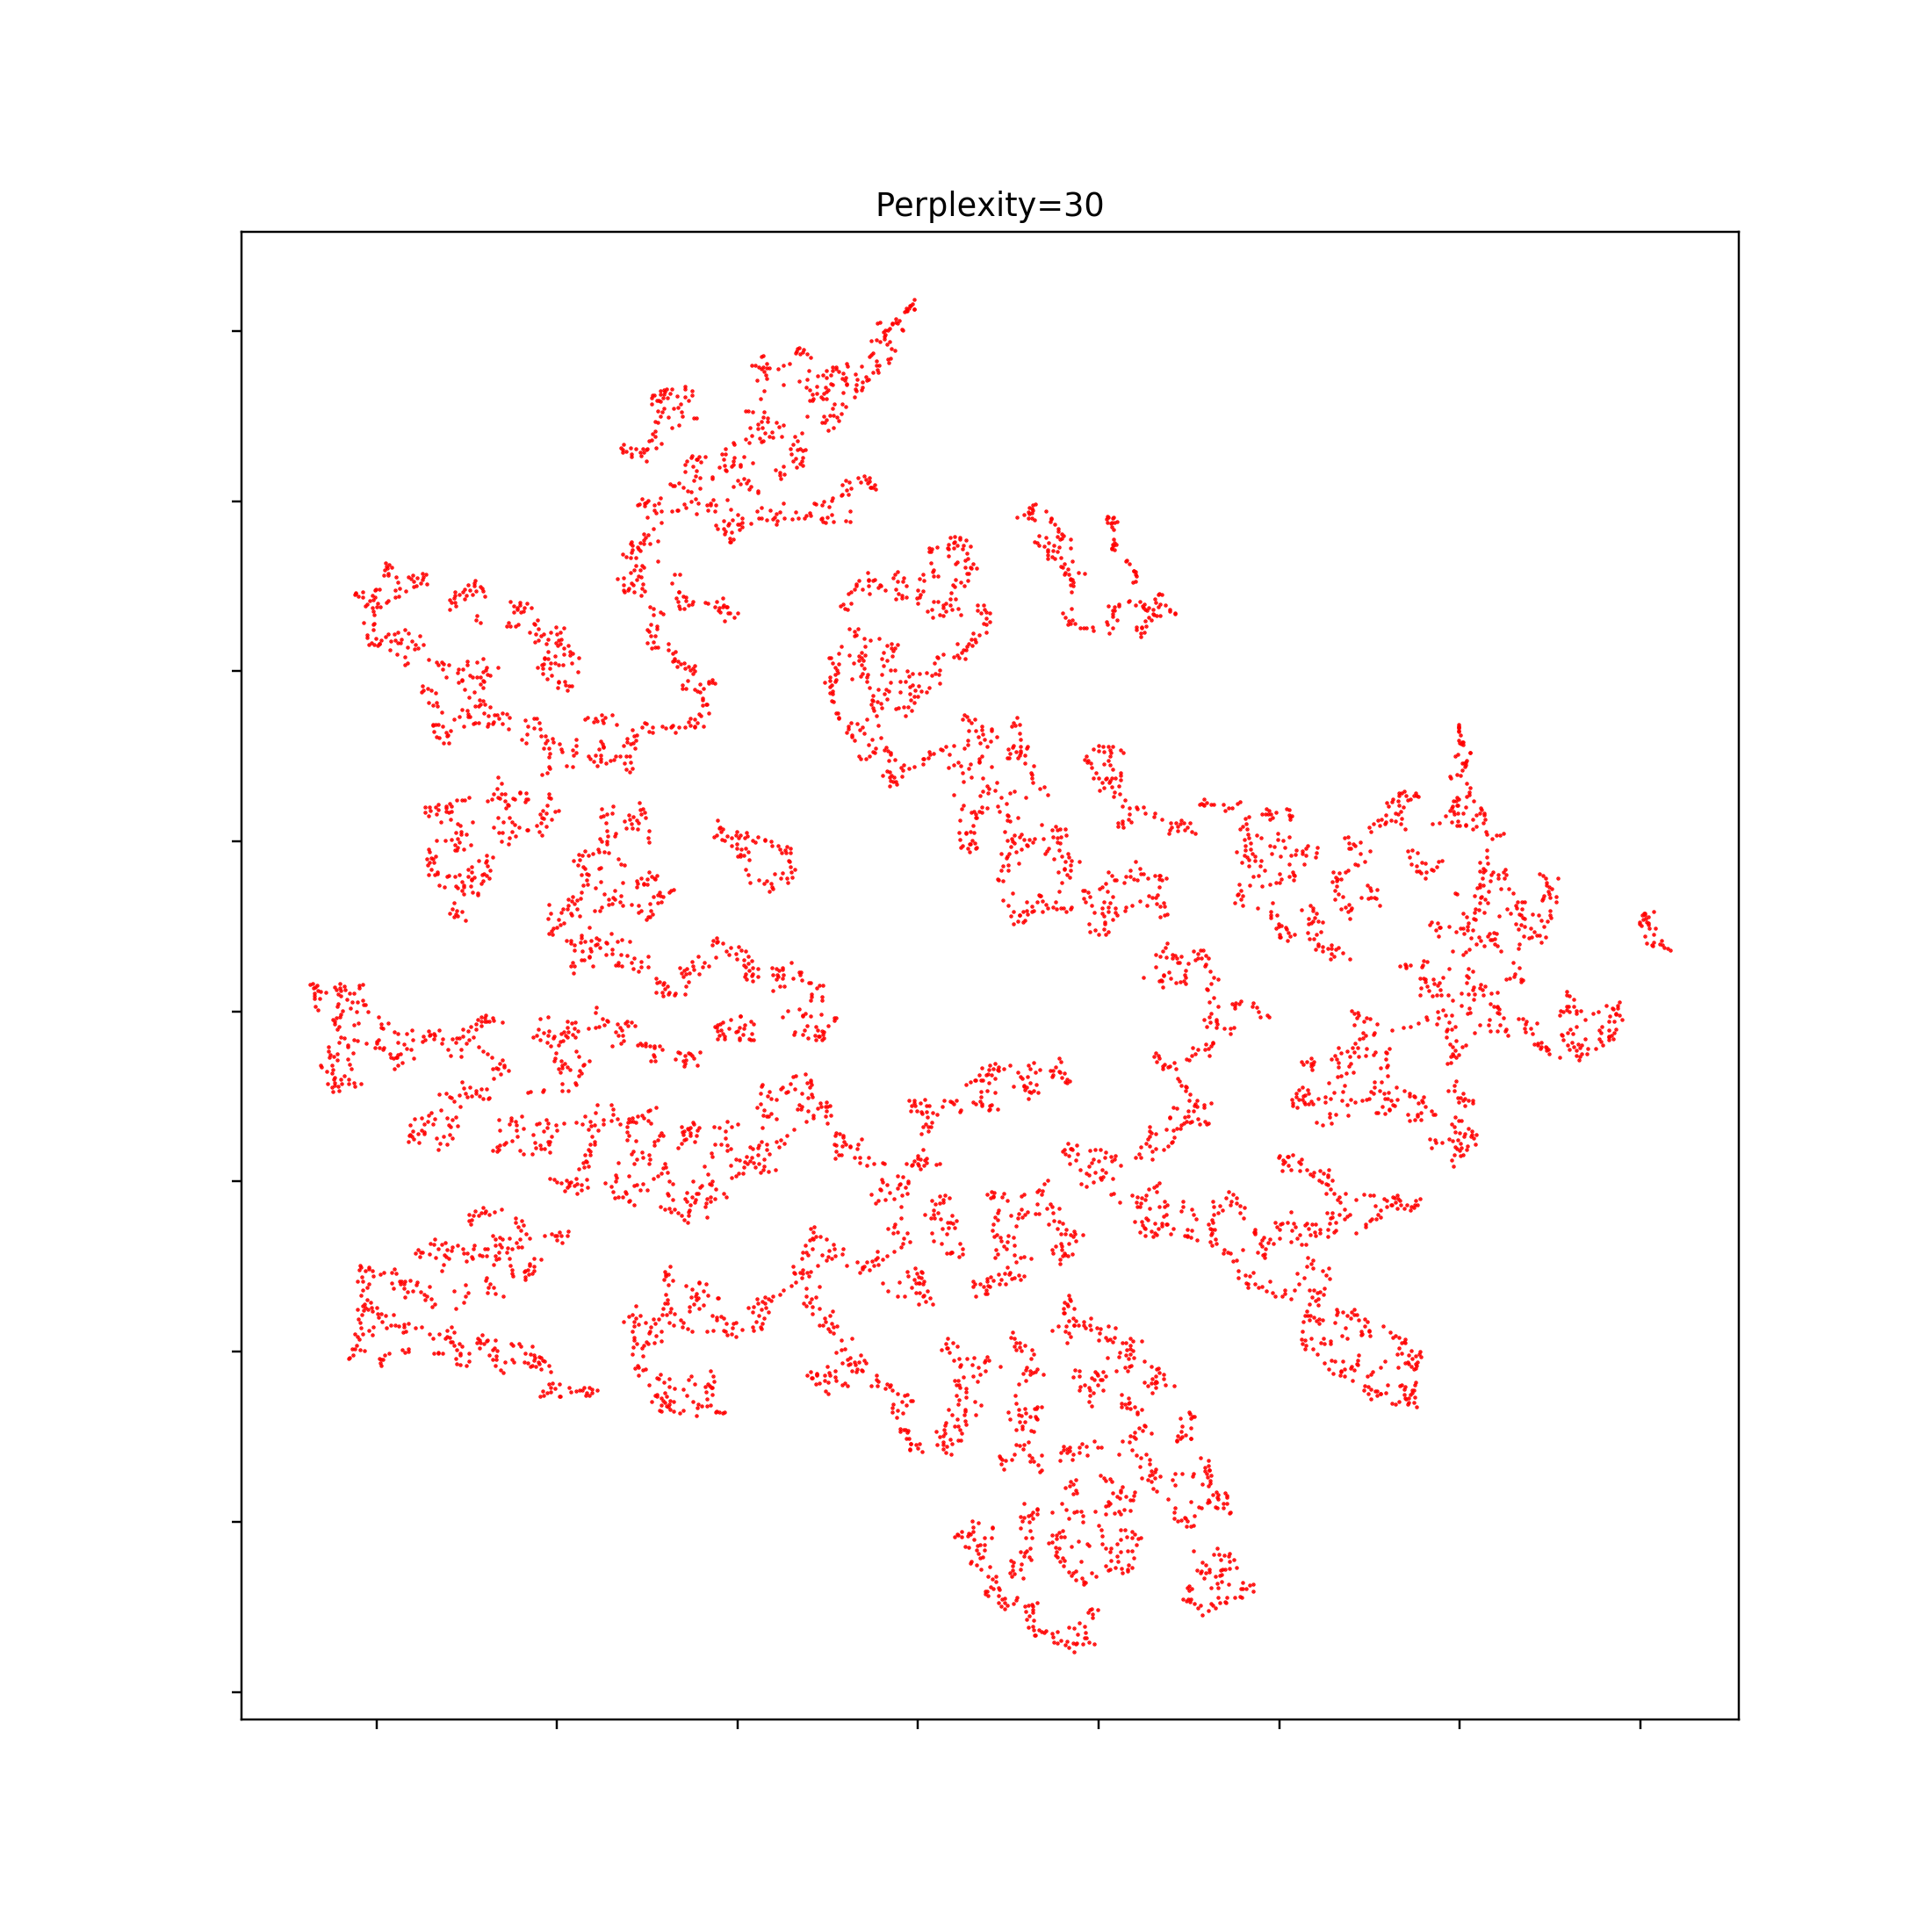

perplexity=30 in 30 sec


In [17]:
# t-sne
n_samples = 300
n_components = 2
perplexities = [30]
(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(10, 10))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i] if isinstance(subplots, list) else subplots

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, n_iter=2500)
    Y = tsne.fit_transform(mats)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c="r", s=0.2)
#     ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
#     break

[[-1.1938594e+01 -5.6427789e+00 -1.3652201e-01]
 [-4.0755954e+02  5.6875385e+01  3.7877750e+00]
 [ 4.2250436e+02 -2.1816074e+01 -3.2013354e+00]
 [ 1.3466654e+01  3.1415655e+01 -6.8651289e-02]
 [-4.2736366e+01  4.3394132e+00 -2.0424709e-01]
 [ 6.8485214e+01  1.3660817e+02  3.2407120e-01]
 [ 7.8747711e+01  1.5516713e-01  6.1031359e-01]
 [ 1.7262283e+01 -7.2168736e+00  1.9393930e-01]]
-712.1477661132812 948.6926879882812
-100.27203369140625 229.1009063720703
-11.454368591308594 14.081525802612305


<IPython.core.display.Javascript object>


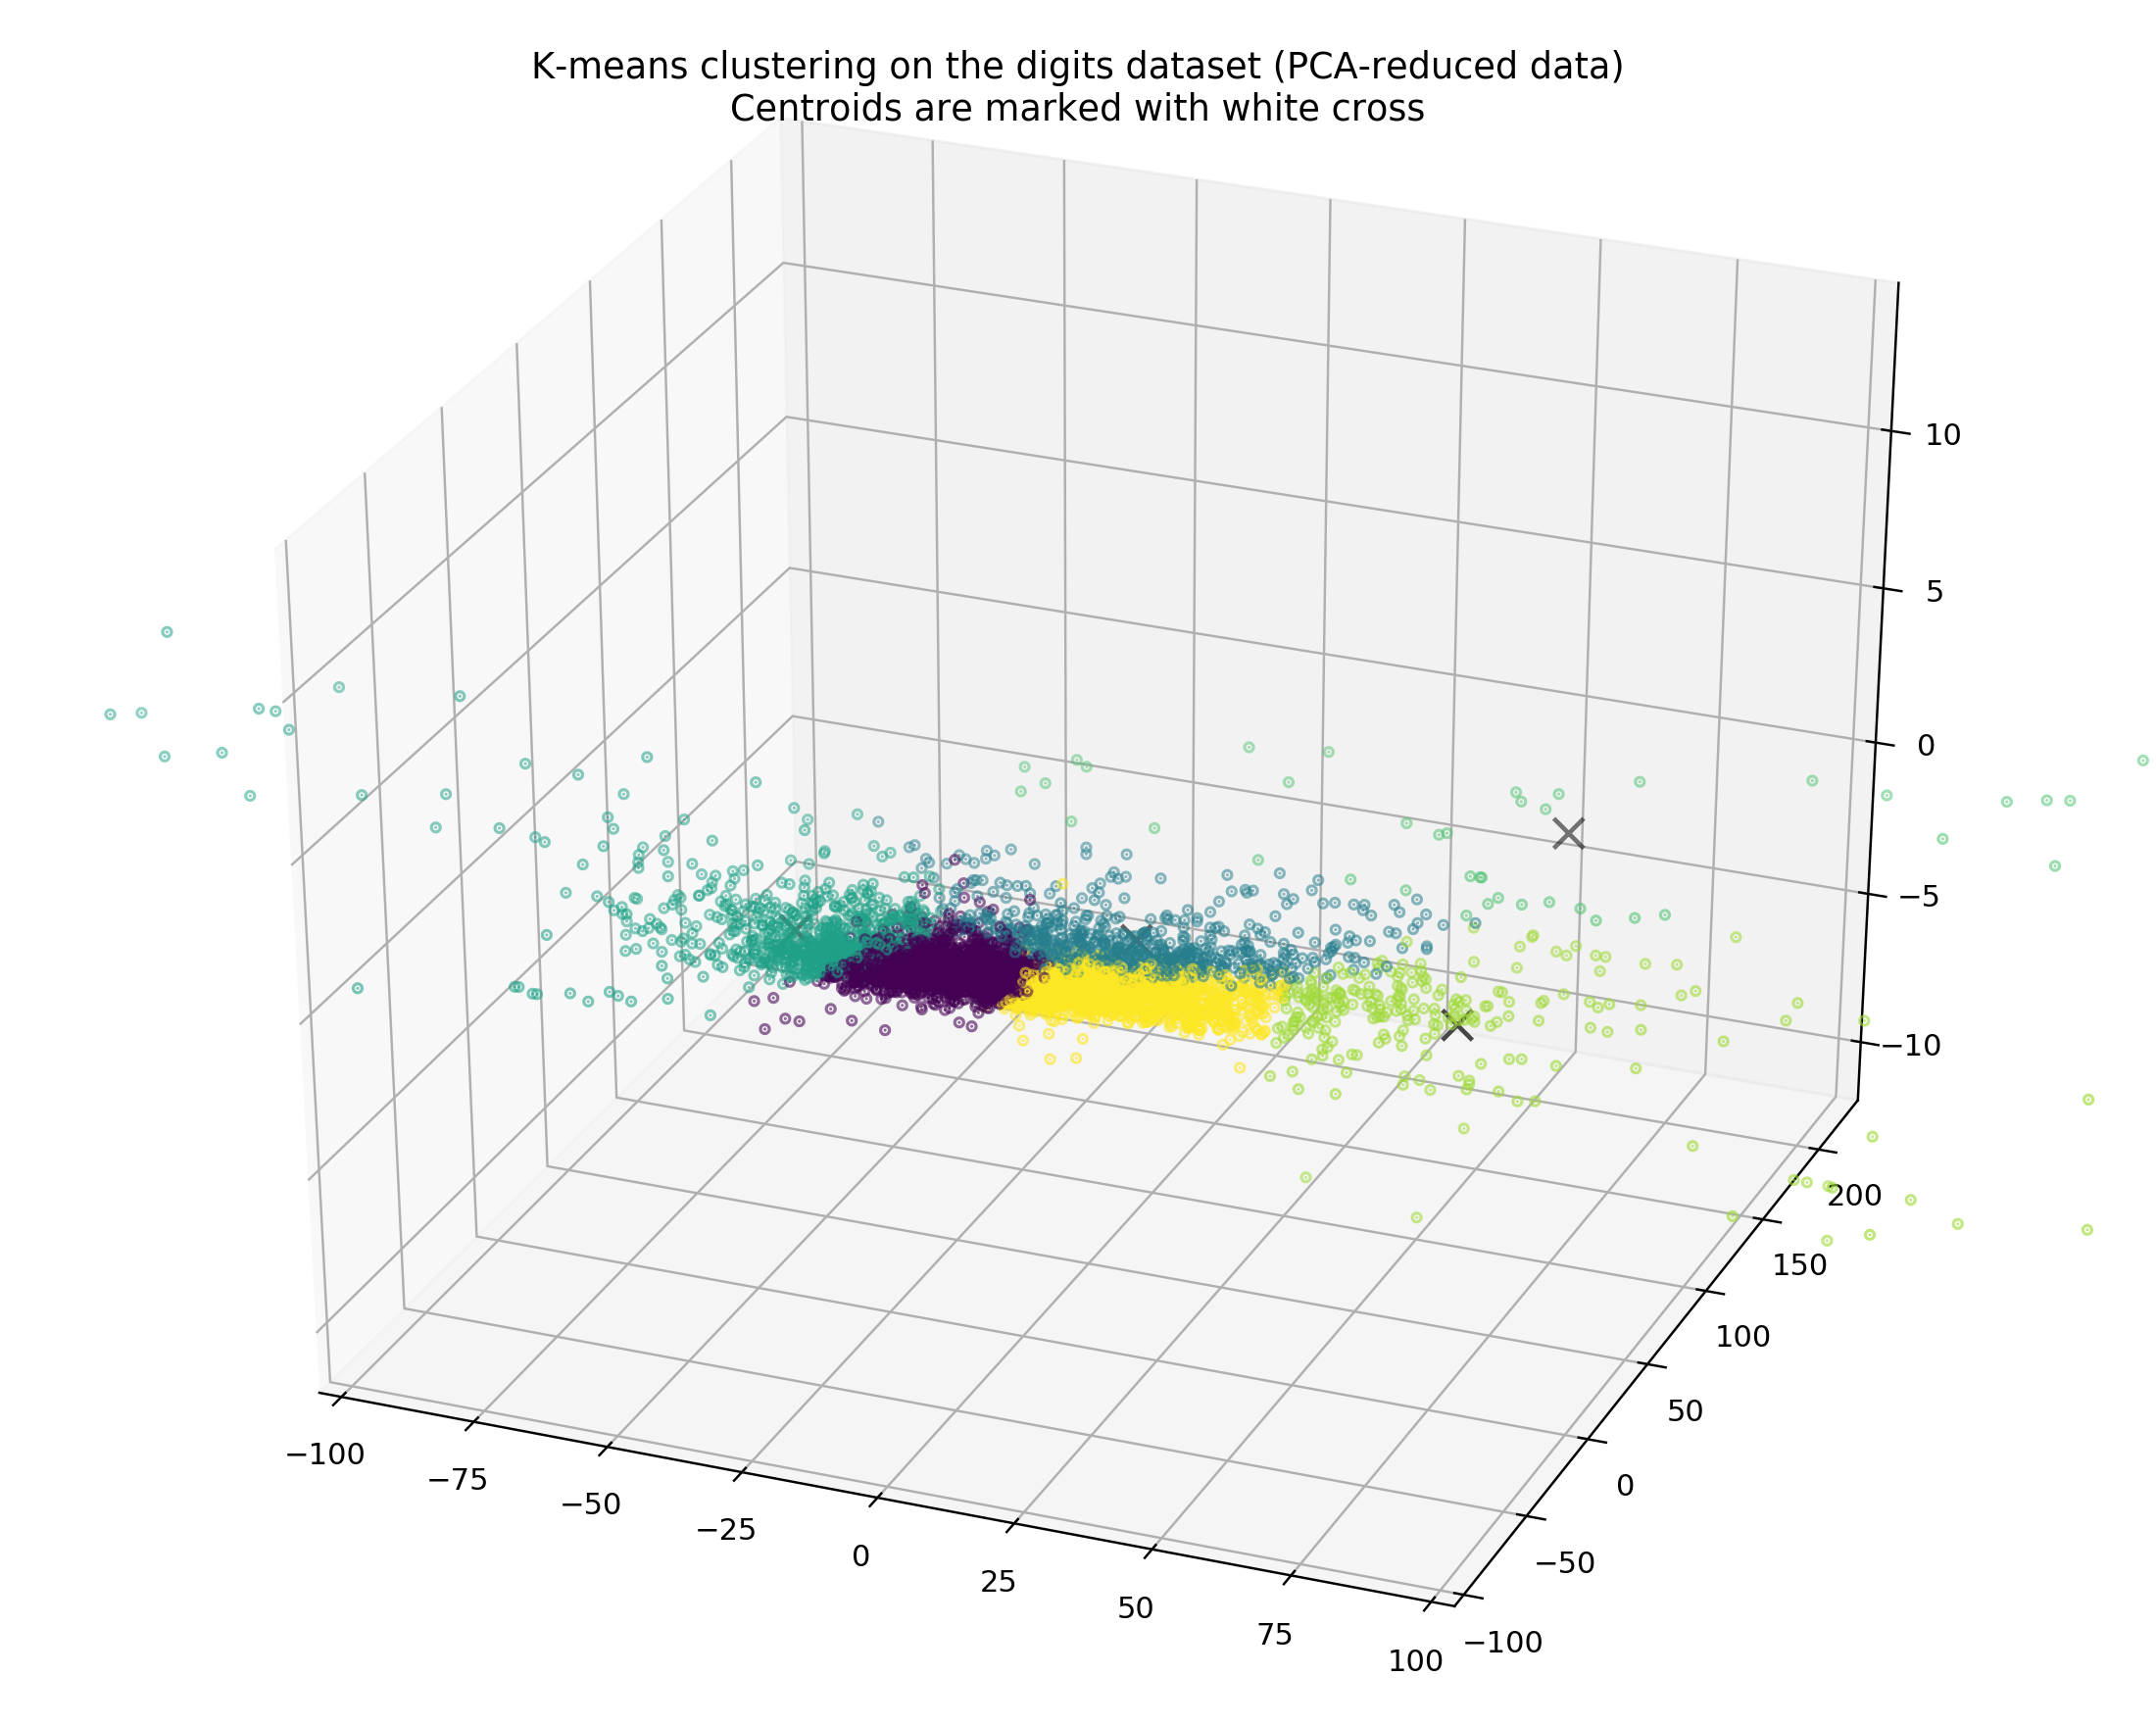

In [10]:
# k-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=3).fit_transform(mats[:, :])
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
z_min, z_max = reduced_data[:, 2].min() - 1, reduced_data[:, 2].max() + 1
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h), np.arange(z_min, z_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max(), zz.min(), zz.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], reduced_dataced_data[:, 2], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(x_min, x_max)
print(y_min, y_max)
print(z_min, z_max)
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
            s=1, linewidths=3,
            c=labels)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
            marker='x', s=100, linewidths=3,
            color='black')
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
ax.set_xlim(-100, 100)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)
# plt.xticks(())
# plt.yticks(())
# plt.zticks(())
plt.show()

<IPython.core.display.Javascript object>


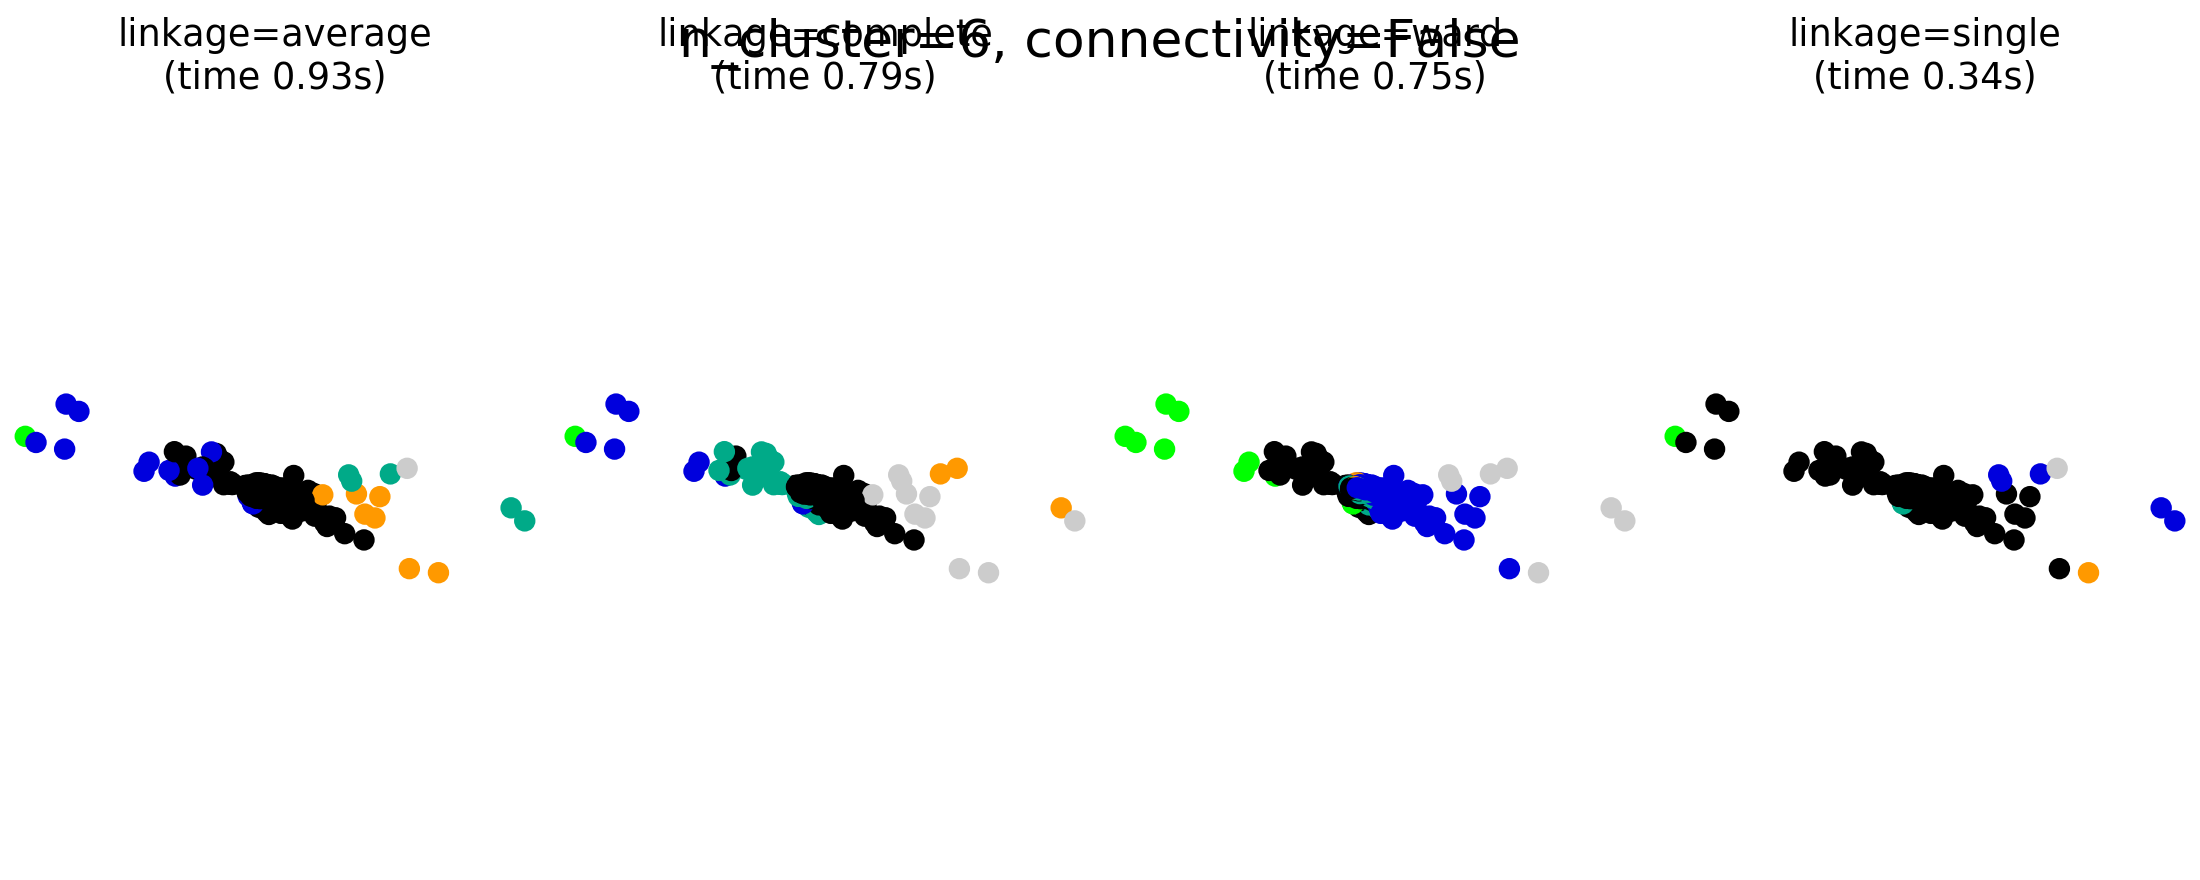

<IPython.core.display.Javascript object>


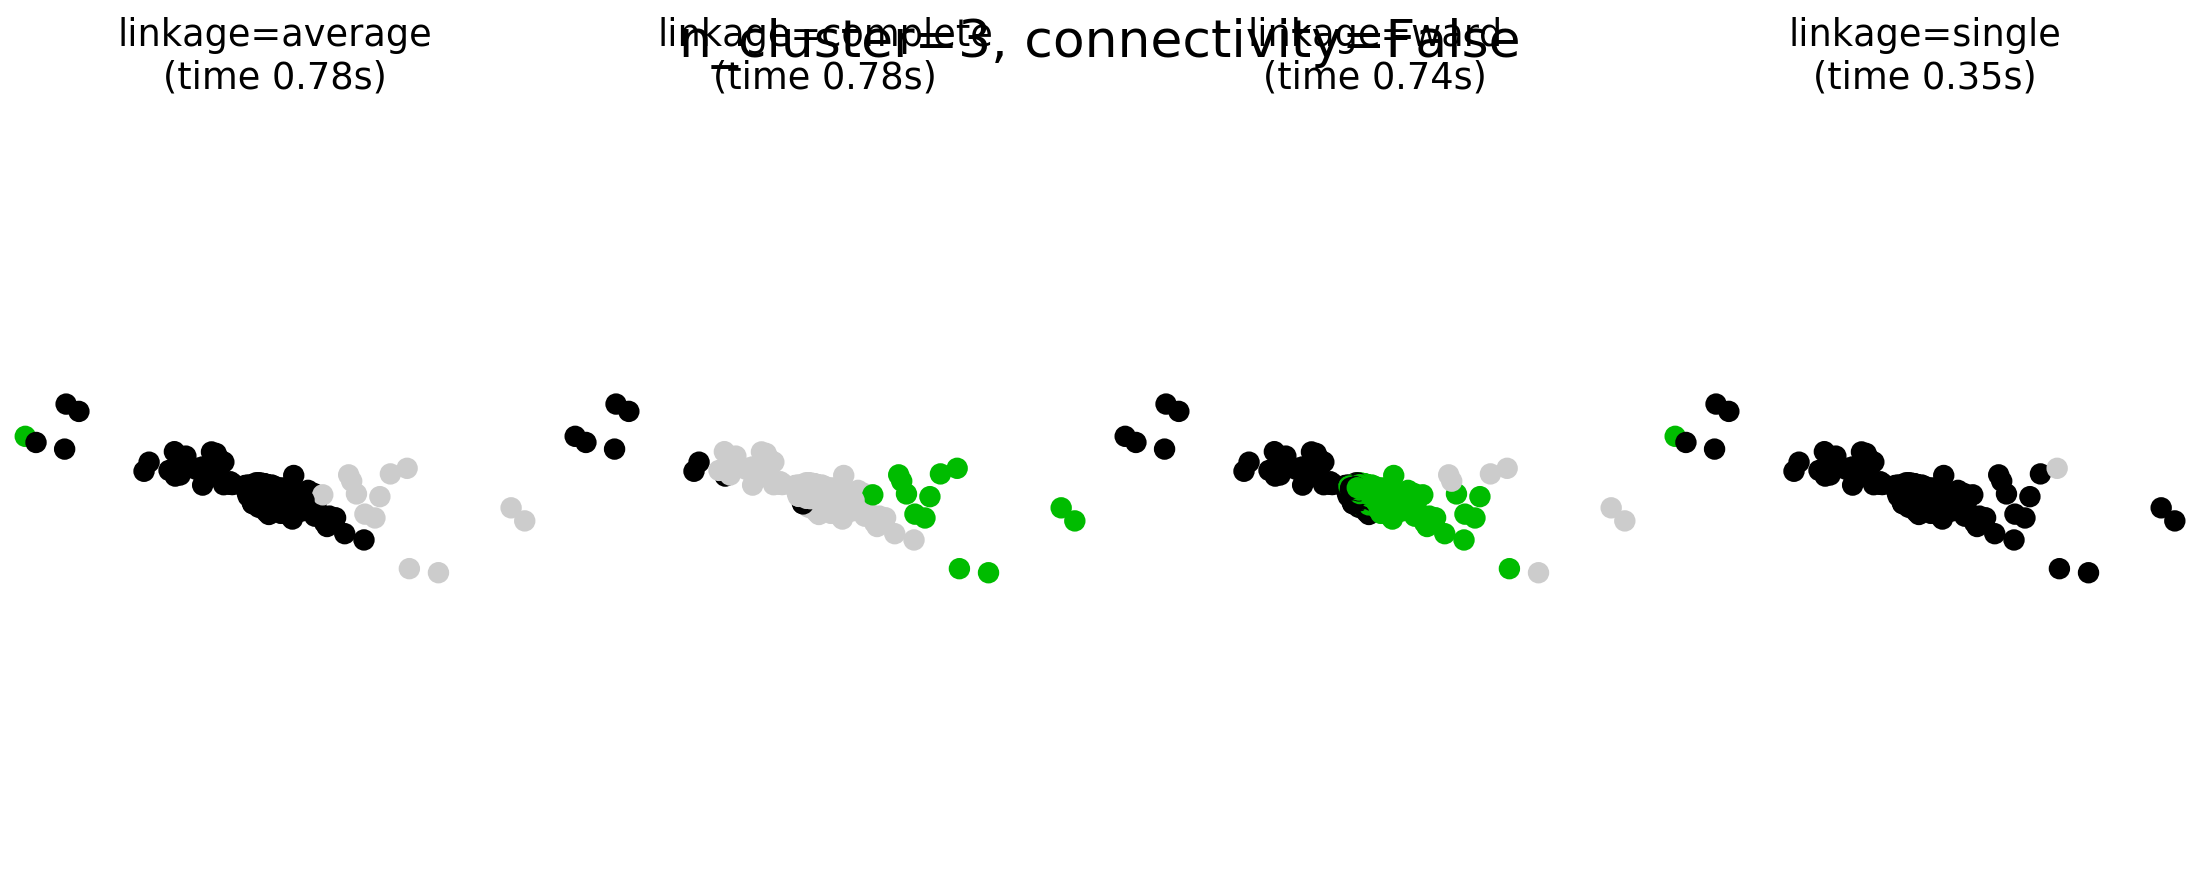

In [3]:
# Agglomerative clustering
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


# print(X.shape)

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
# knn_graph = kneighbors_graph(mats, 500, include_self=False)

for connectivity in (None,):
    for n_clusters in (6, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward',
                                         'single')):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(mats)
            elapsed_time = time.time() - t0
            plt.scatter(mats[:, 0], mats[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

/home/henry/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/henry/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<IPython.core.display.Javascript object>


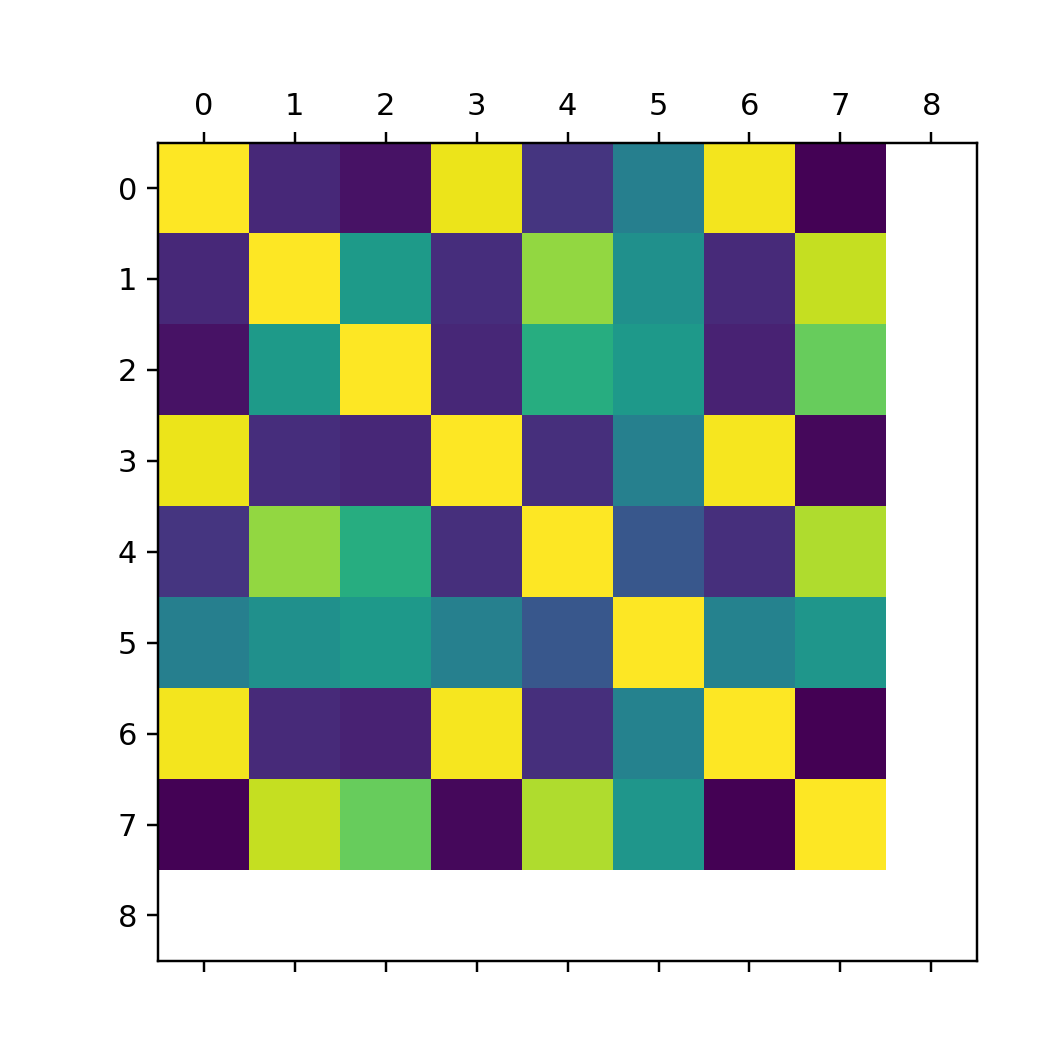

In [6]:
# covariance
# print(mats.shape)
from sklearn.covariance import EmpiricalCovariance
# cov = EmpiricalCovariance().fit(mats)
# print(cov.covariance_)
# fig = plt.figure()
# plt.matshow(cov.covariance_)
# plt.show()
corrcoefs = np.corrcoef(mats, rowvar=False)
# print(corrcoefs)
plt.matshow(corrcoefs)
plt.show()
# mats = mats.reshape(-1, 3, 3)
# print(mats)
# print(mats.shape)
# norms = np.linalg.norm(mats, ord='fro', axis=(1,2))
# print(norms)
# diff = norms.reshape(norms.shape[0], 1, -1) - norms.reshape(1, norms.shape[0], -1)
# diff = np.squeeze(diff)
# print(diff)
# plt.matshow(diff)
# plt.show()

(6160, 9)
Estimated number of clusters: 1
Estimated number of noise points: 79
Silhouette Coefficient: 0.842


<IPython.core.display.Javascript object>


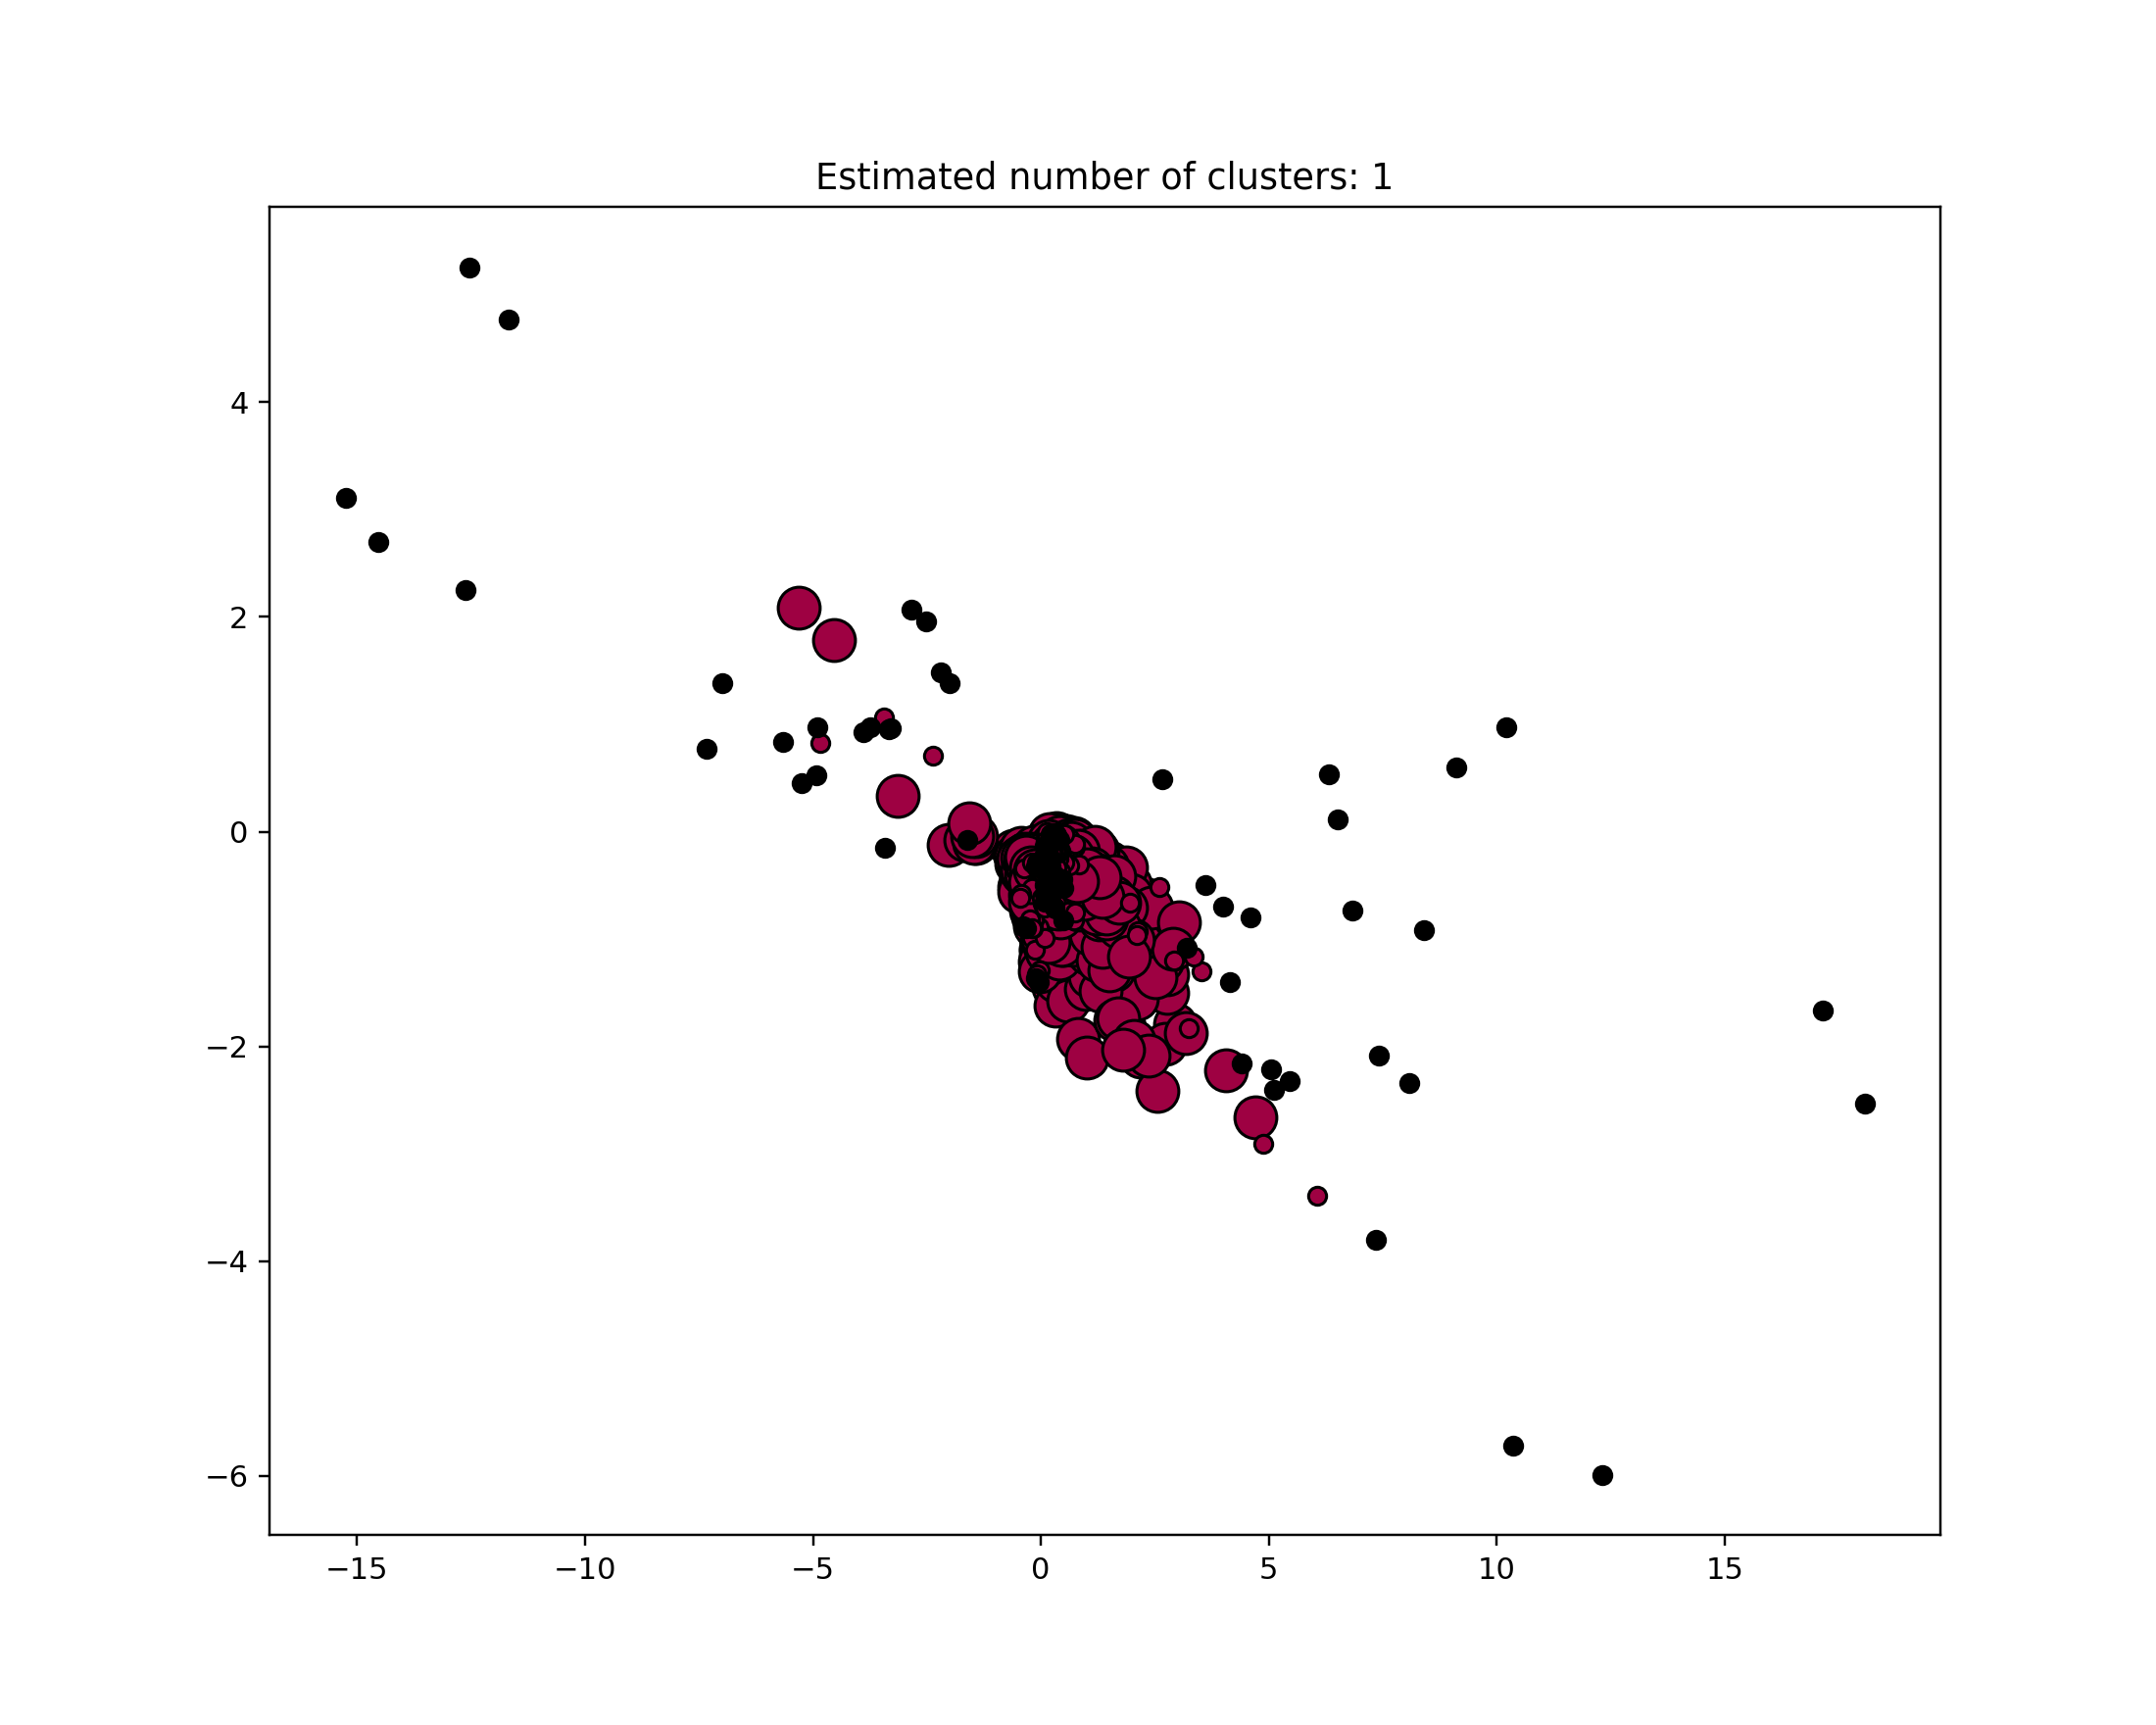

In [17]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Compute DBSCAN
print(mats.shape)
db = DBSCAN(eps=50, min_samples=200).fit(mats)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(mats, labels))

# #############################################################################
# Plot result
fig = plt.figure(figsize=(10, 8))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = mats[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = mats[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 417
Silhouette Coefficient: 0.492


<IPython.core.display.Javascript object>


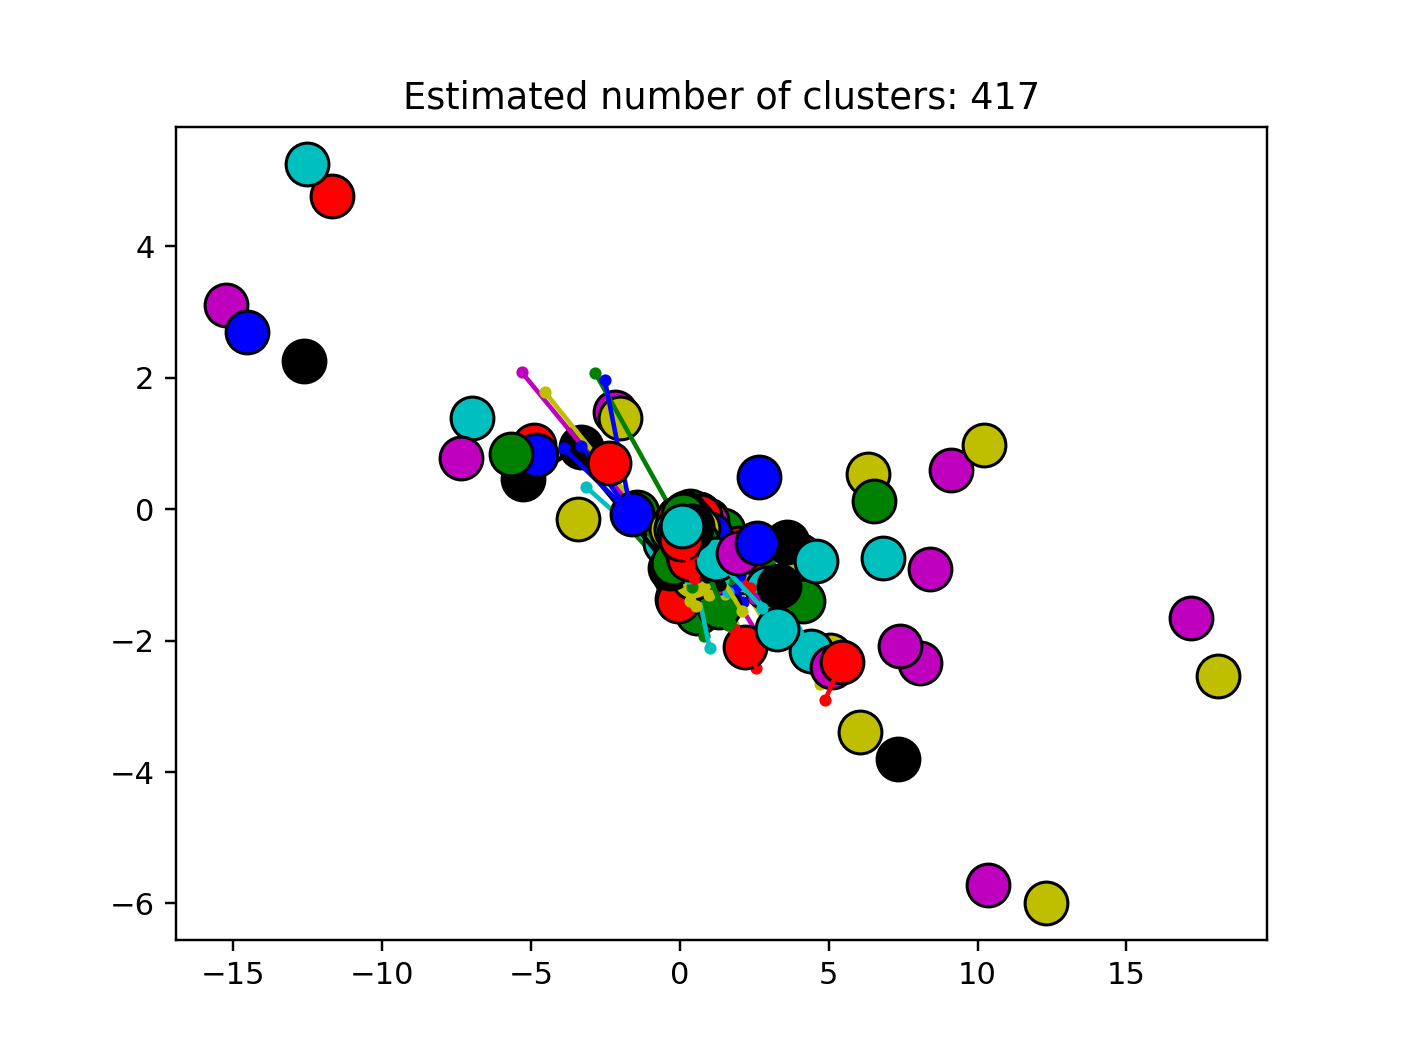

In [18]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs


# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-90).fit(mats)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(mats, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = mats[cluster_centers_indices[k]]
    plt.plot(mats[class_members, 0], mats[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in mats[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
"""

Warp image using perspective transform
======================================

"""


def get_perspective_mat(dataset_dicts):
    

# read the image with OpenCV
# print(os.path.abspath('../../datasets/jnw/total/4770_2.png'))
# img: np.ndarray = cv2.imread('../../../../datasets/jnw/total/new_3285_1.png')

# convert to torch tensor
data: torch.tensor = kornia.image_to_tensor(img, keepdim=False)  # BxCxHxW

# the source points are the region to crop corners
# points_src = torch.tensor([[
#     [82., 60.], [139., 59.], [132., 121.], [101., 121.],
# ]])

single_instance = d['annotations'][0]
points_src = torch.tensor([[[single_instance['keypoints'][3*i], single_instance['keypoints'][3*i+1]] \
for i in range(len(single_instance['keypoints']) // 3)]], dtype=torch.float).repeat(2,1,1)

# the destination points are the image vertexes
h, w = 64, 64  # destination size
# points_dst = torch.tensor([[
#     [w, 0.], [2*w - 1., 0.], [3*w/4 - 1., h - 1.], [w/4., h - 1.],
# ]])
# x1, y1, x2, y2 = single_instance['digit_bboxes'][0]
points_dst = torch.tensor([[
    [digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]],
] for digit_bbox in single_instance['digit_bboxes']], dtype=torch.float)

print(points_src, points_dst)

# compute perspective transform
M: torch.tensor = kornia.get_perspective_transform(points_src, points_dst)

print(M)
points_dst_pred = kornia.transform_points(M, points_src)
print(points_dst_pred)
# equivalent
# points_dst_pred = torch.matmul(M, kornia.convert_points_to_homogeneous(points_src).permute(0,2,1))
# print(kornia.convert_points_from_homogeneous(points_dst_pred.permute(0,2,1)))

# warp the original image by the found transform
# data_warp: torch.tensor = kornia.warp_perspective(data.float(), M, dsize=(h, w))

# convert back to numpy
# img_warp: np.ndarray = kornia.tensor_to_image(data_warp.byte())

# draw points into original image
for i in range(4):
    center = tuple(points_src[0, i].long().numpy())
    img = cv2.circle(img.copy(), center, 5, (0, 255, 0), -1)
    center = tuple(points_dst[0, i].long().numpy())
    img = cv2.circle(img.copy(), center, 5, (255, 0, 0), -1)

# create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

# axs[1].axis('off')
# axs[1].set_title('image destination')
# axs[1].imshow(img_warp)